**Multinomial Regression - Multi-Class Classification - Full Image Data - Normalized Data Set**

**Packages**

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import scipy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from keras.layers import Flatten, Dense, Dropout
import tifffile

2023-03-25 22:14:14.079304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 22:14:14.208962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 22:14:14.208986: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-25 22:14:14.984448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

**Data Pre-Processing**

In [5]:
tiles = pd.read_csv(r'./Data/Tiles_binned_zipcode.csv')
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Split into training and test

In [6]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I',
       'RTTYP_M', 'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']], 
                                   tiles['bin'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Image Pre-Processing

In [7]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        # append to images
        data_mini_test.append(image)
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    return images_mini, images_mini_test

In [8]:
images_mini, images_mini_test = preprocess_data_part1(IMAGE_PATH)

In [9]:
print('train ', np.shape(images_mini))
print('test ', np.shape(images_mini_test))

train  (8376, 148, 188, 4)
test  (2095, 148, 188, 4)


Street Data Pre-Processing

In [10]:
street = np.asarray(x_train[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']]).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
print('train ', np.shape(street_mini))

street_test = np.asarray(x_test[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']]).astype('float32')
street_mini_test = []
for row in range(len(street_test)):
    street_mini_test.append([[street_test[row]]])
street_mini_test = np.stack(street_mini_test)
print('test ',np.shape(street_mini_test))

train  (8376, 1, 1, 52)
test  (2095, 1, 1, 52)


In [11]:
input_image_street = np.hstack(
    (street_mini.reshape((8376,52)),
     images_mini.reshape(8376,148*188*4))
)
np.shape(input_image_street)

(8376, 111348)

In [12]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((2095,52)),
     images_mini_test.reshape(2095,148*188*4))
)
np.shape(input_image_street_test)

(2095, 111348)

Pre-process Label Column

In [13]:
y_train[0:5]

8419     C
10129    B
7641     A
5215     A
7784     A
Name: bin, dtype: object

In [14]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
le.fit(y_test)
y_test = le.transform(y_test)

In [15]:
y_train[0:5]

array([2, 1, 0, 0, 0])

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(input_image_street)
input_image_street_scaled = scaler.transform(input_image_street)
input_image_street_scaled

array([[ 0.9800161 ,  0.97864366, -0.2118546 , ...,  0.29667163,
        -0.16575551,  1.2379174 ],
       [ 1.6275007 ,  1.6140119 , -1.7188627 , ...,  0.33996522,
         0.09994915,  0.41224203],
       [ 0.7508425 ,  0.7562967 ,  0.6253407 , ...,  0.881135  ,
         0.9992572 ,  0.23656642],
       ...,
       [-1.5497296 , -1.5626165 , -1.4843292 , ..., -1.3051909 ,
        -1.1876965 , -0.58910894],
       [ 0.20303467,  0.21637191,  1.5964139 , ...,  0.70796067,
         0.65179724, -0.3958658 ],
       [ 0.9339053 ,  0.94697094,  1.5294043 , ..., -0.41767243,
        -0.02268377, -1.2742438 ]], dtype=float32)

In [17]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(input_image_street_test)
input_image_street_test_scaled = scaler.transform(input_image_street_test)
input_image_street_test_scaled

array([[-1.4871364 , -1.5006756 , -1.514304  , ..., -0.9013086 ,
        -1.2449881 ,  0.614982  ],
       [ 0.25699314,  0.24822415, -1.0483779 , ...,  0.623188  ,
         0.21981801,  0.44097435],
       [ 0.3217365 ,  0.3130223 , -1.0483779 , ..., -2.1209056 ,
        -1.3263662 ,  2.581268  ],
       ...,
       [-1.7880522 , -1.792159  , -0.38278925, ..., -0.2697314 ,
        -0.10569444, -1.142495  ],
       [-1.5561022 , -1.565257  , -1.0150774 , ..., -0.05194619,
        -0.55327404,  0.8933942 ],
       [ 0.66318727,  0.6693038 ,  0.682265  , ...,  1.0152013 ,
         1.0539436 ,  0.3365698 ]], dtype=float32)

In [18]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],'max_depth': [20,30,40, 100, 110],
#     'max_features': ['sqrt'],'min_samples_leaf': [5,10,15],
#     'min_samples_split': [40,50,60], 'n_estimators': [150, 200, 250]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [19]:
# grid_search.fit(X_scaled, y_train)

In [20]:
# grid_search.best_params_

**Logistic Regression**

**Modeling**

In [21]:
class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
               }

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111348)]          0         
                                                                 
 dense (Dense)               (None, 11)                1224839   
                                                                 
Total params: 1,224,839
Trainable params: 1,224,839
Non-trainable params: 0
_________________________________________________________________


2023-03-25 22:15:45.561831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-25 22:15:45.569024: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-25 22:15:45.580143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-03-25 22:15:45.604282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 22:15:46.129140: W tensorflow/tsl/framework/cpu_allocator

Epoch 1/30
210/210 [==============================] - 3s 10ms/step - loss: 9858.1201 - accuracy: 0.1300 - val_loss: 44.5744 - val_accuracy: 0.1217
Epoch 2/30
210/210 [==============================] - 2s 9ms/step - loss: 6213.0366 - accuracy: 0.2197 - val_loss: 45.5691 - val_accuracy: 0.1277
Epoch 3/30
210/210 [==============================] - 2s 9ms/step - loss: 4686.3735 - accuracy: 0.2690 - val_loss: 47.3912 - val_accuracy: 0.0865
Epoch 4/30
210/210 [==============================] - 2s 9ms/step - loss: 3821.8047 - accuracy: 0.3103 - val_loss: 46.9086 - val_accuracy: 0.1044
Epoch 5/30
210/210 [==============================] - 2s 9ms/step - loss: 3142.5405 - accuracy: 0.3642 - val_loss: 50.8387 - val_accuracy: 0.1169
Epoch 6/30
210/210 [==============================] - 2s 9ms/step - loss: 2889.2815 - accuracy: 0.3787 - val_loss: 52.2745 - val_accuracy: 0.0996
Epoch 7/30
210/210 [==============================] - 2s 9ms/step - loss: 2807.5979 - accuracy: 0.3793 - val_loss: 54.8194 

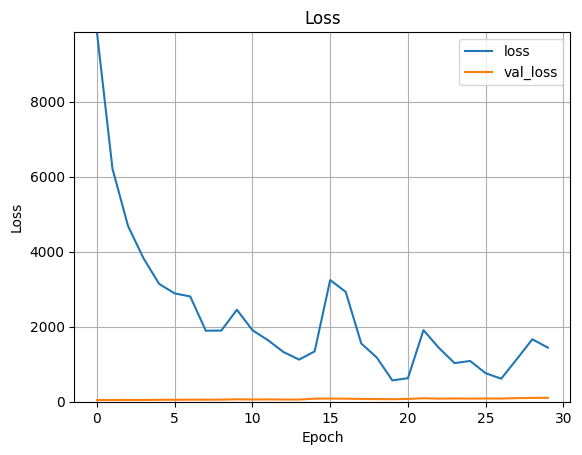

In [22]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'
tf.keras.backend.clear_session()
def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111348,))
    
    # input = keras.layers.Flatten()(input)

    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

history = logistic_model.fit(
    input_image_street_scaled,
    y_train,
     # y_train_2,
    epochs=30,
    # Suppress logging.
     # verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

plot_loss(history)

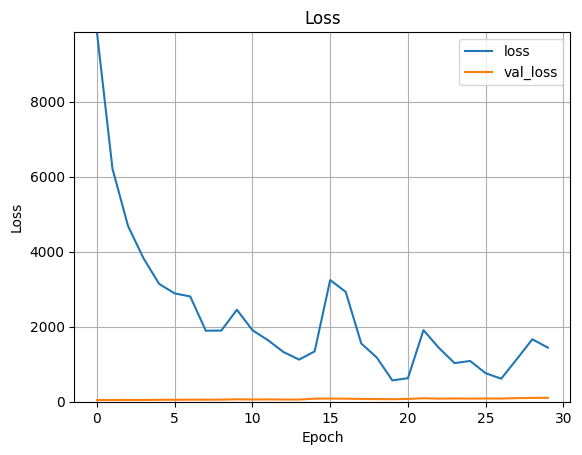

In [23]:
plot_loss(history)

In [24]:
predict_result = history.model.predict(input_image_street_test_scaled)

66/66 [==============================] - 0s 3ms/step


In [25]:
predictions = []
for x in range(len(predict_result)):
    predictions.append(np.argmax(predict_result[x]))

In [26]:
f1_score(y_test, predictions, average=None, sample_weight=None, zero_division='warn')

array([0.45290023, 0.27799228, 0.08661417, 0.02072539, 0.01398601,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [27]:
f1_score(y_test, predictions, average=None, sample_weight=None, zero_division='warn').mean()

0.07747437143874875